# Refine Regions of Interest and Select EIS Raster Scans

This notebook produces the table of AIA cutouts for the AR over three rotations and attaches other necessary metdata to this table

In [1]:
import pathlib

import astropy.io.ascii
import astropy.units as u
import astropy.table
import astropy.time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
import pandas

from sunpy.net import Fido, attrs as a
from sunpy.net.fido_factory import UnifiedResponse
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective, get_earth, get_horizons_coord,propagate_with_solar_surface

Next, we're going to take a look at a few ARs that were observed repeatedly over multiple rotations. this is a dataset produced by Emily Mason. This cleans up the table a bit and adds more context to these ARs.

In [2]:
mason_ars = astropy.table.QTable.from_pandas(pandas.read_excel('../data/tables/ars_and_times_emason.xlsx'))
# Time
mason_ars['Date start'] = astropy.time.Time(mason_ars['Date1'])
mason_ars['Date end'] = astropy.time.Time(mason_ars['Date2'])
mason_ars['Date mid'] = mason_ars['Date start'] + (mason_ars['Date end'] - mason_ars['Date start'])/2
# Coordinates
blc = []
trc = []
for row_m,row in zip(mason_ars.mask, mason_ars):
    if row_m['bottom_left_x']:
        blc_Tx = row['X'] - row['W'] / 2
        blc_Ty = row['Y'] - row['H'] / 2
        trc_Tx = row['X'] + row['W'] / 2
        trc_Ty = row['Y'] + row['H'] / 2
    else:
        blc_Tx = row['bottom_left_x']
        blc_Ty = row['bottom_left_y']
        trc_Tx = row['top_right_x']
        trc_Ty = row['top_right_y']
    frame = Helioprojective(observer=get_horizons_coord('SDO', time=row['Date mid']), obstime=row['Date mid'])
    blc.append(SkyCoord(Tx=blc_Tx*u.arcsec, Ty=blc_Ty*u.arcsec, frame=frame))
    trc.append(SkyCoord(Tx=trc_Tx*u.arcsec, Ty=trc_Ty*u.arcsec, frame=frame))
mason_ars['bottom left'] = blc
mason_ars['top right'] = trc
# Clean up
mason_ars.rename_column('Unnamed: 12', 'Comment')
mason_ars.remove_columns([
    'Date1',
    'Date2',
    'Unnamed: 11',
    'bottom_left_x',
    'top_right_x',
    'bottom_left_y',
    'top_right_y',
    'X', 
    'Y', 
    'W',
    'H',
])

# Adding an ID that designates which ARs are the same from one rotation to the next
mason_ars['Region ID'] = 0
for i,row in enumerate(mason_ars):
    if i > 0:
        time_delta = row['Date mid'] - mason_ars[i-1]['Date mid']
        if time_delta < (30 * u.day):
            row['Region ID'] = mason_ars[i-1]['Region ID']
        else:
            row['Region ID'] = mason_ars[i-1]['Region ID'] + 1

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS loca

Next, I'm going to pare this table down to one region.

In [3]:
mason_ars = mason_ars[mason_ars['Region ID']==1]

And I'm going to manually adjust a few of the dates to avoid some flares and such that the intervals are roughly centered on the EIS rasters that we care about.

In [4]:
mason_ars[0]['Date start'] = astropy.time.Time('2014-01-08 06:00:00')
mason_ars[0]['Comment'] = "Adjusted start time to avoid flare on 2014-01-07 18:00:00"
mason_ars[1]['Date start'] = astropy.time.Time('2014-02-03 05:00:00')
mason_ars[1]['Comment'] = "Adjusted start time to center interval on EIS raster scan"
mason_ars[2]['Date start'] = astropy.time.Time('2014-03-01 18:00:00')
mason_ars[2]['Comment'] = "Adjusted start time to avoid eclipse on 2014-03-02 06:00:00"
mason_ars['Date end'] = mason_ars['Date start'] + 12*u.h
mason_ars['Date mid'] = mason_ars['Date start'] + (mason_ars['Date end'] - mason_ars['Date start'])/2

In [5]:
mason_ars

<QTable length=3>
NOAA AR ... Region ID
 int64  ...   int64  
------- ... ---------
  11944 ...         1
  11967 ...         1
  11990 ...         1

Now, need to adjust the bounding boxes for each AR.

In [8]:
q = Fido.search(
    a.AttrOr([a.Time(r['Date start'], end=r['Date end'], near=r['Date mid']) for r in mason_ars]),
    a.Instrument.aia,
    a.Wavelength(171*u.AA),
)
aia_files = Fido.fetch(q) #path='../data/AIA/level_1/{file}')
#mason_ars.add_column(list(aia_files), name='AIA context image')

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1.171A_2014_03_01T23_59_59.34Z.image_lev1.fits:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

aia.lev1.171A_2014_02_03T10_59_59.34Z.image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia.lev1.171A_2014_01_08T11_59_59.34Z.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Now that I've changed the intervals a bit, I also need to adjust the fields of view. I did this manually...

In [6]:
frame = Helioprojective(observer=get_horizons_coord('SDO', time=mason_ars[0]['Date mid']), obstime=mason_ars[0]['Date mid'])
mason_ars[0]['bottom left'] = SkyCoord(Tx=-200*u.arcsec, Ty=-330*u.arcsec, frame=frame)
mason_ars[0]['top right'] = SkyCoord(Tx=330*u.arcsec, Ty=100*u.arcsec, frame=frame)

frame = Helioprojective(observer=get_horizons_coord('SDO', time=mason_ars[1]['Date mid']), obstime=mason_ars[1]['Date mid'])
mason_ars[1]['bottom left'] = SkyCoord(Tx=-278*u.arcsec, Ty=-400*u.arcsec, frame=frame)
mason_ars[1]['top right'] = SkyCoord(Tx=260*u.arcsec, Ty=0*u.arcsec, frame=frame)

frame = Helioprojective(observer=get_horizons_coord('SDO', time=mason_ars[2]['Date mid']), obstime=mason_ars[2]['Date mid'])
mason_ars[2]['bottom left'] = SkyCoord(Tx=-350*u.arcsec, Ty=-400*u.arcsec, frame=frame)
mason_ars[2]['top right'] = SkyCoord(Tx=150*u.arcsec, Ty=0*u.arcsec, frame=frame)

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


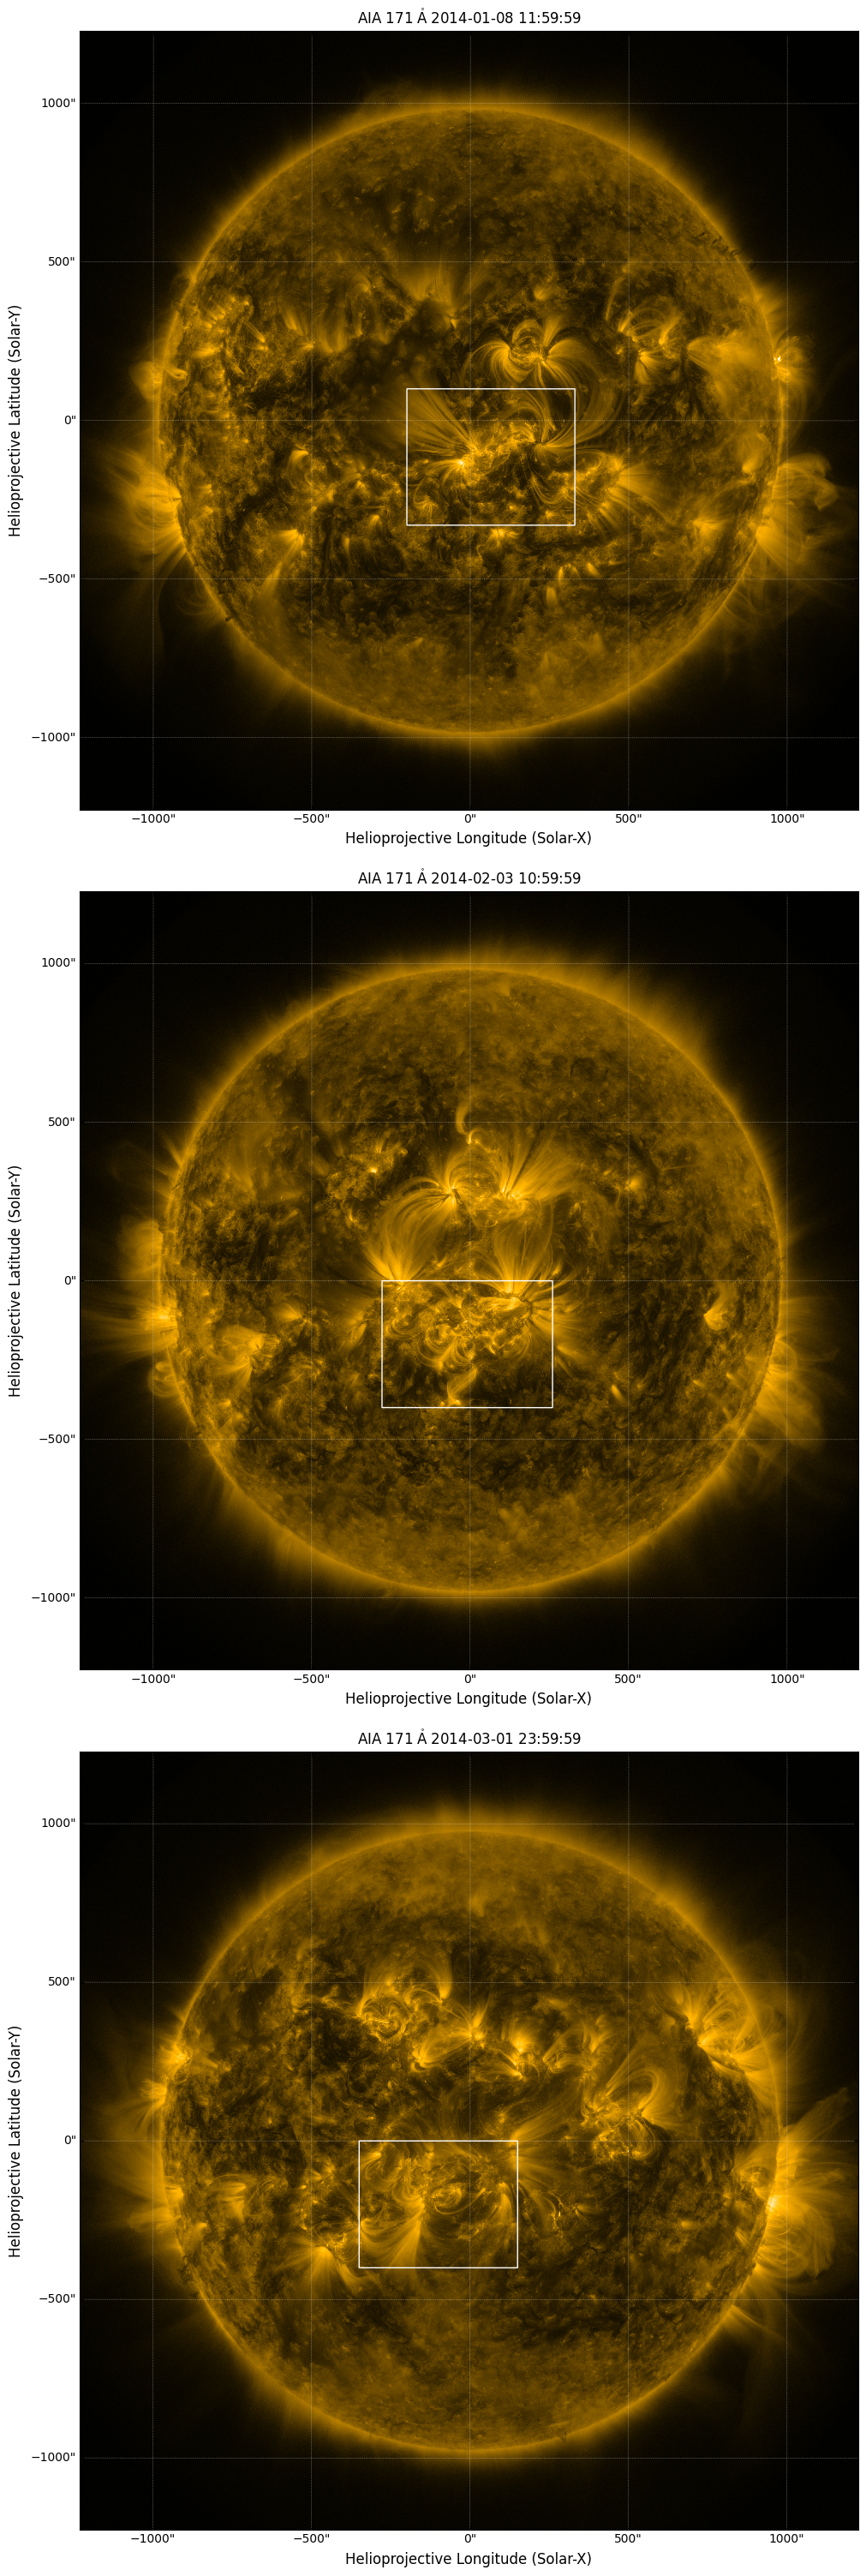

In [12]:
# Plot selected FOV on context images
fig = plt.figure(figsize=(10,30), layout='constrained')
for i,(row,file) in enumerate(zip(mason_ars,aia_files)):
    m = sunpy.map.Map(file)
    ax = fig.add_subplot(len(mason_ars), 1, i+1, projection=m)
    m.plot(axes=ax)
    m.draw_quadrangle(row['bottom left'], top_right=row['top right'], facecolor='k')

Now, let's add the associated EIS file to this table. I manually selected and downloaded these.

In [7]:
mason_ars.add_column(['eis_20140108_095727','eis_20140203_093134','eis_20140302_000659'],
                     name='EIS file')

I'm also adding in XRT here. I'm doing this a bit manually because there are some filter wheel combinations I'd rather not include and if the observation is too far from the EIS raster midpoint, I'd also rather not include it.

In [31]:
q = Fido.search(
    a.AttrOr([a.Time(r['Date start'], end=r['Date end'], near=r['Date mid']) for r in mason_ars]),
    a.Instrument.xrt,
)

In [32]:
xrt_files = Fido.fetch(q)

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

In [33]:
xrt_maps = sunpy.map.Map(xrt_files)

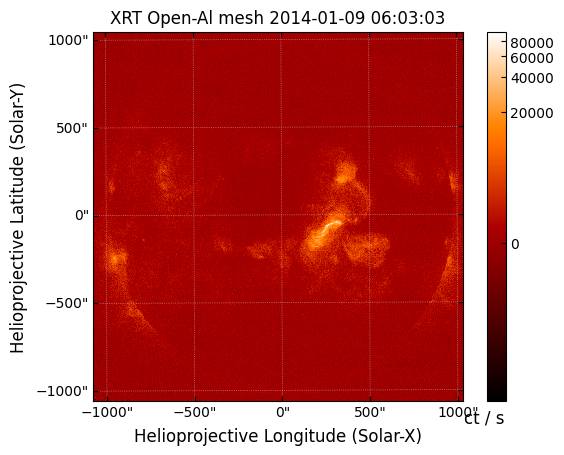

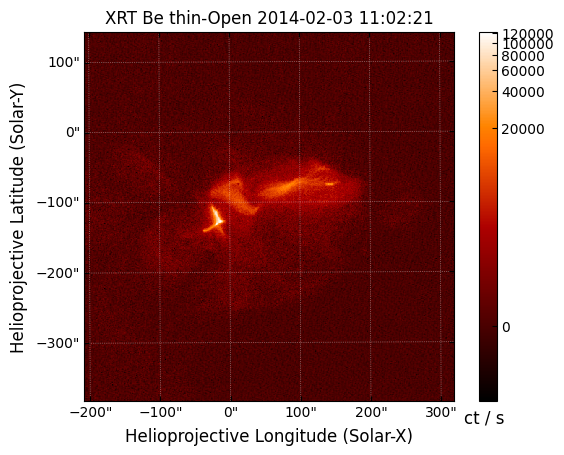

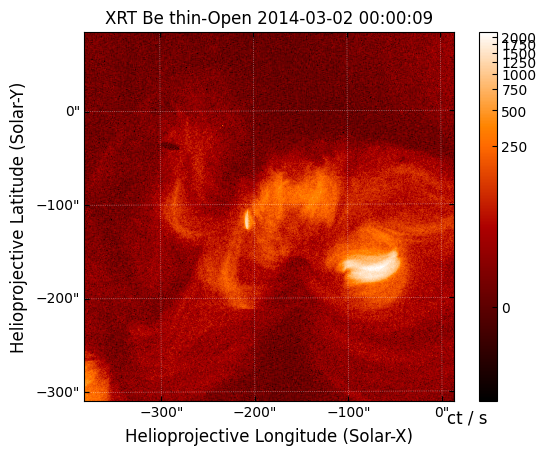

In [34]:
for m in xrt_maps:
    m.peek()

Note that the XRT observation for the first pass is much later than the EIS raster and only the Al-mesh filter is available so I'm ditching that one.

In [35]:
xrt_files

['/Users/wtbarnes/sunpy/data/L1_XRT20140109_060303.1.fits', '/Users/wtbarnes/sunpy/data/L1_XRT20140203_110221.2.fits', '/Users/wtbarnes/sunpy/data/L1_XRT20140302_000009.0.fits']

In [8]:
mason_ars.add_column(['', 'L1_XRT20140203_110221.2.fits', 'L1_XRT20140302_000009.0.fits'],
                     name='XRT file')

In [9]:
mason_ars

<QTable length=3>
NOAA AR ...           XRT file          
 int64  ...            str28            
------- ... ----------------------------
  11944 ...                             
  11967 ... L1_XRT20140203_110221.2.fits
  11990 ... L1_XRT20140302_000009.0.fits

Lastly, we're just going to make some adjustments so we can serialize our table to a file.

In [10]:
# Cannot serialize a column of SkyCoord objects when each one is in a different coordinate frame
serializable_table = mason_ars.copy()
serializable_table.replace_column(
    'bottom left',
    u.Quantity([u.Quantity([r['bottom left'].Tx,r['bottom left'].Ty]) for r in serializable_table]),
)
serializable_table.replace_column(
    'top right',
    u.Quantity([u.Quantity([r['top right'].Tx,r['top right'].Ty]) for r in serializable_table]),
)
serializable_table.remove_column('Region ID')
serializable_table.write('../data/tables/mason_ars_region_1.asdf')

In [11]:
serializable_table

<QTable length=3>
NOAA AR ...           XRT file          
        ...                             
 int64  ...            str28            
------- ... ----------------------------
  11944 ...                             
  11967 ... L1_XRT20140203_110221.2.fits
  11990 ... L1_XRT20140302_000009.0.fits